# Project 3: Web APIs & NLP (Part 2)

## Problem Statement

Our Social Media department has informed us that users of our newly created Beauty Insider Community Forum have been posting in the wrong group. 

The makeup and perfumes posts are posted in the General Discussion page and we need to find a way to classify their posts into Makeup and Perfumes categories for better analysis of their needs and interests.

We will be using Reddit posts from r/Makeup and r/Perfumes to create a text classifier model that can classify posts into the 2 categories with accuracy more than 50% (baseline accuracy). We can then use the model to classify the posts in our forum. Through this project, we will also find out the trending words in each subreddit to guide our marketing department.

In [1]:
import pandas as pd
import string
import re
import nltk
nltk.download('wordnet')

wn = nltk.WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wujin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import the 2 datasets
makeup = pd.read_csv('../data/makeup.csv')         
perfumes = pd.read_csv('../data/perfumes.csv')       

In [3]:
# Concatenate both datasets
makeup_perfumes = pd.concat([makeup, perfumes], ignore_index=True)
makeup_perfumes.shape

(9998, 85)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Cleaning

In [5]:
# Check for duplicate rows
duplicaterows = makeup_perfumes[makeup_perfumes.duplicated()]

In [6]:
len(duplicaterows)

0

There are no duplicate rows in the dataset.

In [7]:
makeup_perfumes.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts',
       'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'suggested_sort', 'thumbnail', 'title',


In [8]:
# relevant information are in 'title','selftext','subreddit'
makeup_perfumes = makeup_perfumes[['title','selftext','subreddit']]

In [9]:
makeup_perfumes.head()

,title,selftext,subreddit
0,Prepping skin with Paula’s choice liquid exfol...,I got my makeup done for a friend’s wedding (n...,Makeup
1,Bare minerals vs. glossier vs. thrive cosmetics?,Hi! Trying to incorporate makeup back into my ...,Makeup
2,Does Ulta / Sephora allow you to return an ite...,"The purchase history is in my Ulta app, so i t...",Makeup
3,Covering My Birthmark,Hi everyone\n\nI have a cafe au lait birthmark...,Makeup
4,Palette Review &amp; Pictorial • BH Cosmetics:...,"[Pictures are available on my profile, if you ...",Makeup


In [10]:
makeup_perfumes.isnull().sum()

title           0
selftext     2877
subreddit       0
dtype: int64

In [11]:
makeup_perfumes.isnull()
makeup_perfumes[makeup_perfumes['selftext'].isnull()]

,title,selftext,subreddit
8,What do my brows need?,NaN,Makeup
11,What do my eyebrows need?,NaN,Makeup
26,Can you use concealer with bb creams?,NaN,Makeup
27,Is witch hazel safe for all skin types?,NaN,Makeup
58,Makeup For Wedding For Bride,NaN,Makeup
79,How can I apply lashes easier? I'm all good ap...,NaN,Makeup
104,Do you remember the alphabet here?,NaN,Makeup
105,"Hi, I am looking for THE ONE. Chanel volume vs...",NaN,Makeup
112,Best brand for makeup brushes?,NaN,Makeup
114,I need a cheap foundation that can cover (or a...,NaN,Makeup


2877 out of 9998 rows are null for the column 'selftext'. It could be because the posts have information in the title instead. We can replace null values in 'selftext' and [deleted] and [removed] posts with '' and then combine the 'selftext' and 'title' columns.

In [12]:
makeup_perfumes[(makeup_perfumes['selftext'] == '[deleted]')]

,title,selftext,subreddit
3419,do these lashes ned glue or not? It says full ...,[deleted],Makeup
3639,Clean Dupe for MUFE Aqua Seal?,[deleted],Makeup
3641,What are your favorite underrated drugstore pr...,[deleted],Makeup
4073,Any Smudgeproof dupes for mac verlebet teddy?,[deleted],Makeup
6852,What are your favorite scents from Cocoa Pink?,[deleted],Perfumes
8210,Is it just me or is Gucci Flora identical to V...,[deleted],Perfumes
8377,Did I bought the a fake perfume?,[deleted],Perfumes
8679,Ughhh obsessed,[deleted],Perfumes
8680,This gives out an irresistible sillage and mak...,[deleted],Perfumes
8681,This conditioner smells amazing and gives out ...,[deleted],Perfumes


In [13]:
# Change subreddit categories to 0 and 1 for further processing of machine learning models.
makeup_perfumes['subreddit'] = makeup_perfumes['subreddit'].map({'Makeup': 0, 'Perfumes': 1})

In [14]:
makeup_perfumes['selftext'] = makeup_perfumes['selftext'].fillna('')
makeup_perfumes['selftext'] = makeup_perfumes['selftext'].replace(['[deleted]'],'')
makeup_perfumes['selftext'] = makeup_perfumes['selftext'].replace(['[removed]'],'')

We will combine both 'selftext' and 'title' together for the modelling process.

In [15]:
# Concatenating both columns together with a space
makeup_perfumes['title_selftext'] = makeup_perfumes['title']+ ' ' + makeup_perfumes['selftext']

# Drop the original columns as the combined column has been created
makeup_perfumes.drop(['title', 'selftext'], axis= 1, inplace=True)

# Use Regex to remove non alphabets
makeup_perfumes['title_selftext'] = makeup_perfumes['title_selftext'].str.replace('[^a-zA-Z ]', '')

C:\Users\wujin\AppData\Local\Temp/ipykernel_6932/1013258150.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  makeup_perfumes['title_selftext'] = makeup_perfumes['title_selftext'].str.replace('[^a-zA-Z ]', '')


In [16]:
makeup_perfumes.isnull().sum()

subreddit         0
title_selftext    0
dtype: int64

## EDA

C:\Users\wujin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

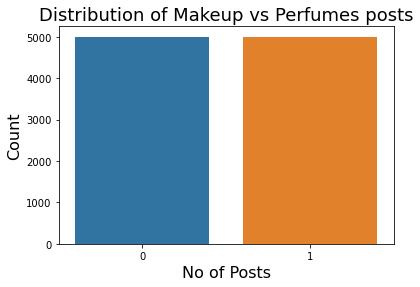

In [17]:
tick_labels = ["r/Makeup", "r/Perfumes"]

sns.countplot(makeup_perfumes["subreddit"])

plt.title("Distribution of Makeup vs Perfumes posts", size = 18)
plt.xlabel("No of Posts", size = 16)
plt.ylabel("Count", size = 16)


We see that the number of makeup and perfumes posts are around the same at 5,000 count each.

In [18]:
# Find out word count for each post
makeup_perfumes['word_count'] = makeup_perfumes['title_selftext'].apply(lambda x: len(x.split()))
makeup_perfumes.head()

,subreddit,title_selftext,word_count
0,0,Prepping skin with Paulas choice liquid exfoli...,90
1,0,Bare minerals vs glossier vs thrive cosmetics ...,77
2,0,Does Ulta Sephora allow you to return an item...,47
3,0,Covering My Birthmark Hi everyoneI have a cafe...,27
4,0,Palette Review amp Pictorial BH Cosmetics Avo...,363


C:\Users\wujin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

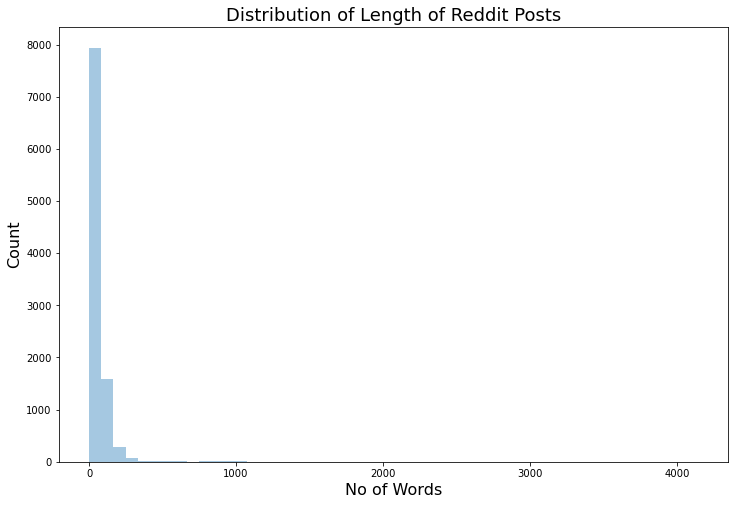

In [44]:
plt.figure(figsize = (12,8))
sns.distplot(makeup_perfumes['word_count'], kde=False)
plt.title("Distribution of Length of Reddit Posts", size = 18)
plt.xlabel("No of Words", size = 16)
plt.ylabel("Count", size = 16)

Majority of the Reddit posts have low word count of around 100-200.

Text(0, 0.5, 'Count')

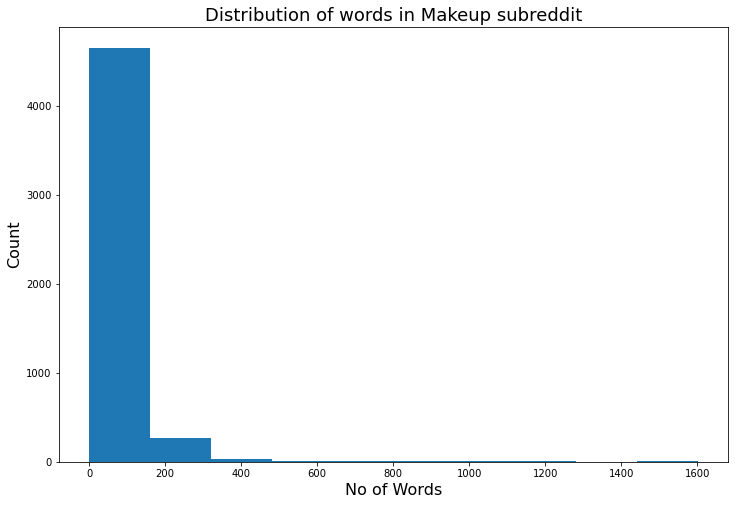

In [43]:
plt.figure(figsize = (12,8))
plt.hist(makeup_perfumes[makeup_perfumes['subreddit'] == 0]['word_count'])
# plt.xlim(0, 600)
plt.title('Distribution of words in Makeup subreddit', size = 18)
plt.xlabel('No of Words', size = 16)
plt.ylabel('Count', size = 16)

Most of the posts in Makeup subreddit have 100-300 words.

Text(0, 0.5, 'Count')

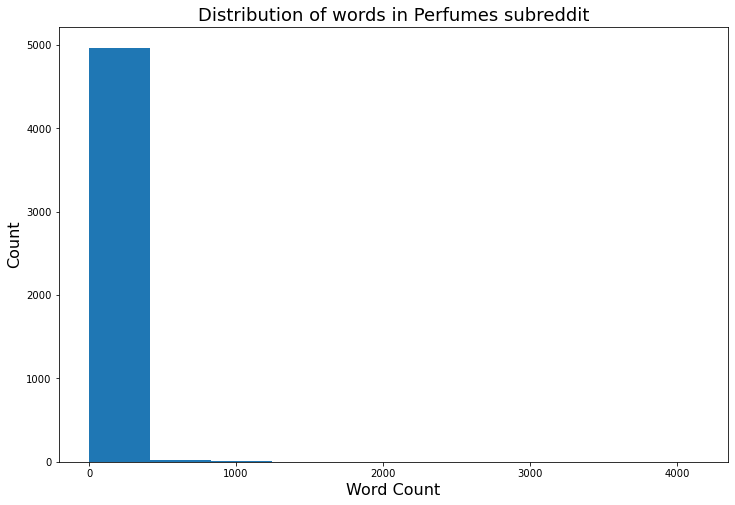

In [47]:
plt.figure(figsize = (12,8))
plt.hist(makeup_perfumes[makeup_perfumes['subreddit'] == 1]['word_count'])
plt.title('Distribution of words in Perfumes subreddit', size = 18)
plt.xlabel('Word Count', size = 16)
plt.ylabel('Count', size = 16)

Similarly most of the posts in Perfumes subreddit have 100-300 words.

### Apply CountVectorizer (w/ N-Grams)

In [22]:
def plot_top_words(subreddit_name, subreddit_num, title_selftext, n_min, n_max, n_words):
    
    X = makeup_perfumes[makeup_perfumes['subreddit'] == subreddit_num][title_selftext]
    
    cvec = CountVectorizer(ngram_range = (n_min,n_max), stop_words='english').fit(X)
    
    X = cvec.transform(X)
    
    X_cvec = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
    
    fsize = 18
    plt.figure(figsize = (10,10))
    X_cvec.sum().sort_values(ascending = False).head(n_words).plot(kind = 'barh');
    plt.title(f'Top words in {subreddit_name}', fontsize = fsize)
    plt.xlabel('Number of occurrences', fontsize = fsize)
    plt.xticks(fontsize = fsize)
    plt.yticks(fontsize = fsize)
    plt.tight_layout()

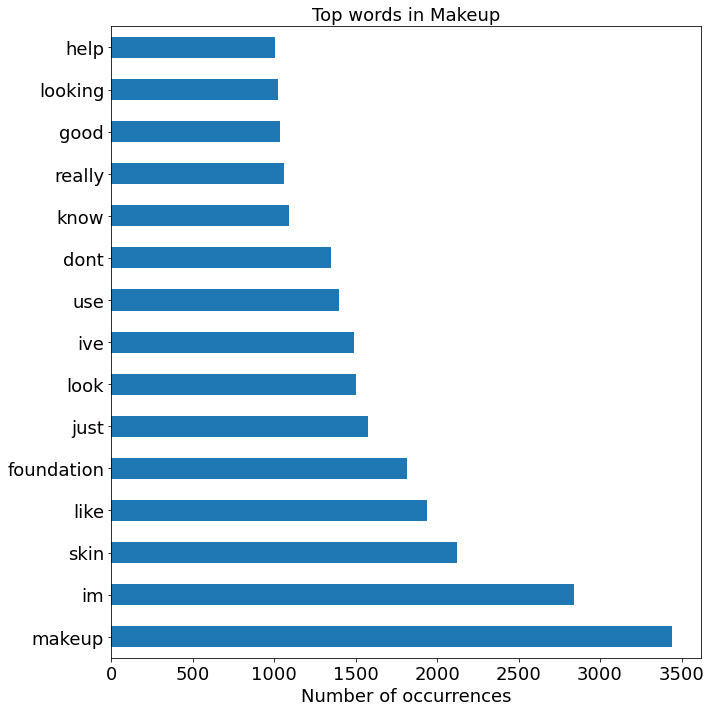

In [23]:
plot_top_words('Makeup', 0, 'title_selftext', 1, 1, 15)

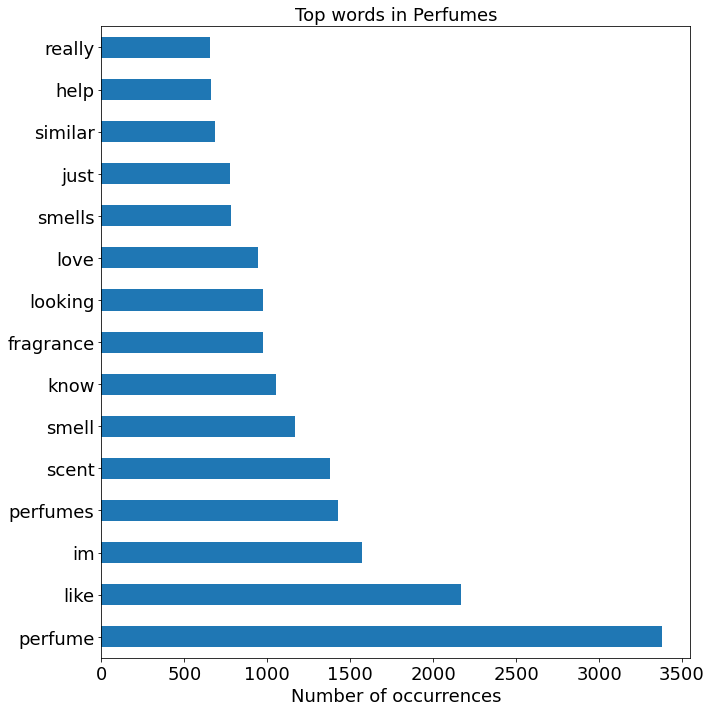

In [24]:
plot_top_words('Perfumes', 1, 'title_selftext', 1, 1, 15)

There are several common words that appear in both subreddits hence we will need to add them to our own stop words list.
We also need to do lemmatization of the words as the singular and plural forms are both in the lists.

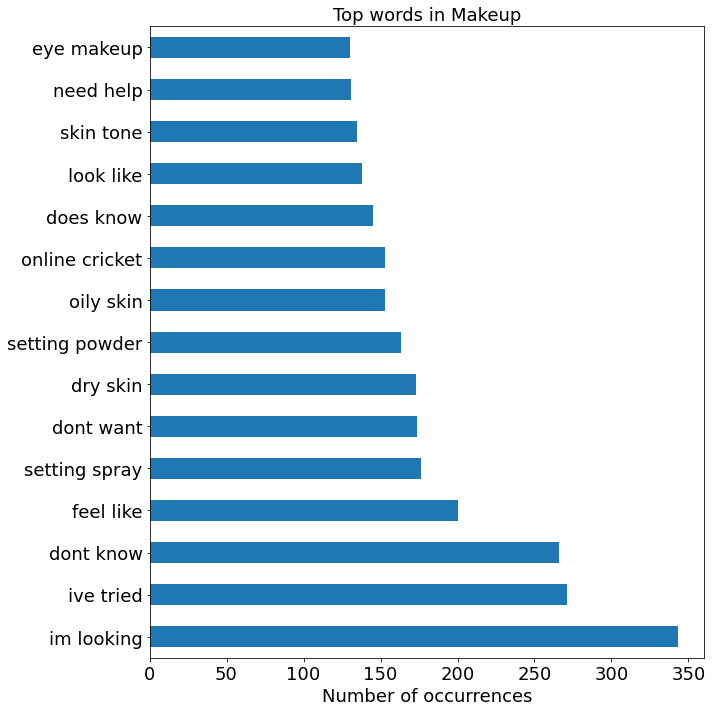

In [49]:
#bi-gram
plot_top_words('Makeup', 0, 'title_selftext', 2, 2, 15)

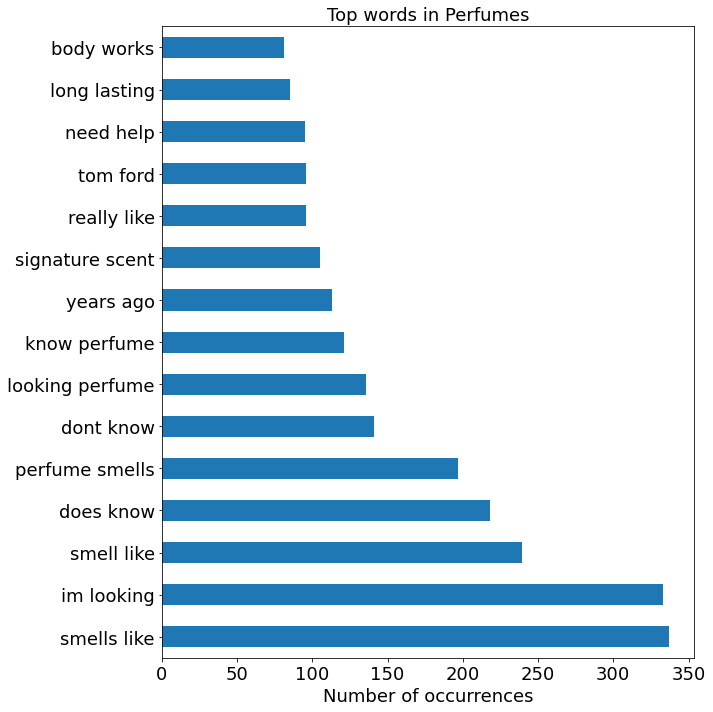

In [26]:
plot_top_words('Perfumes', 1, 'title_selftext', 2, 2, 15)

Similarly, we will add some words that are not so relevant for our analysis to our list of stop words.

In [89]:
# Adding our stopwords to the stopwords set

new_stopwords = ['makeup', 'im', 'skin', 'like', 'just', 'look', 'ive', 'use', 'dont', 'know', 
                 'really', 'good', 'help', 'perfume', 'perfumes', 'smell', 'fragrance', 'scent', 'love', 'similar', 
                 'need','want', 'online', 'cricket', 'thanks', 'advance', 'year', 'ago', 'make', 'wear', 'buy', 'looking', 
                 'smells', 'bottle', 'think', 'new', 'got', 'fragrances', 'hi', 'best', 'body']

stopwords.extend(new_stopwords)

In [90]:
def tokenize(text):
    # Matches any character that is neither alphanumeric nor underscore
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens

makeup_perfumes['title_selftext_tokenized'] = makeup_perfumes['title_selftext'].apply(lambda x: tokenize(x.lower()))

makeup_perfumes.head()

,subreddit,title_selftext,word_count,title_selftext_tokenized,title_selftext_nostop,title_selftext_lemmatized
0,0,Prepping skin with Paulas choice liquid exfoli...,90,"[prepping, skin, with, paulas, choice, liquid,...","[prepping, paulas, choice, liquid, exfoliant, ...",prepping paulas choice liquid exfoliant done f...
1,0,Bare minerals vs glossier vs thrive cosmetics ...,77,"[bare, minerals, vs, glossier, vs, thrive, cos...","[bare, minerals, vs, glossier, vs, thrive, cos...",bare mineral v glossier v thrive cosmetic hi t...
2,0,Does Ulta Sephora allow you to return an item...,47,"[does, ulta, sephora, allow, you, to, return, ...","[ulta, sephora, allow, return, item, without, ...",ulta sephora allow return item without box pac...
3,0,Covering My Birthmark Hi everyoneI have a cafe...,27,"[covering, my, birthmark, hi, everyonei, have,...","[covering, birthmark, hi, everyonei, cafe, au,...",covering birthmark hi everyonei cafe au lait b...
4,0,Palette Review amp Pictorial BH Cosmetics Avo...,363,"[palette, review, amp, pictorial, bh, cosmetic...","[palette, review, amp, pictorial, bh, cosmetic...",palette review amp pictorial bh cosmetic avoca...


In [91]:
def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopwords]
    return text

makeup_perfumes['title_selftext_nostop'] = makeup_perfumes['title_selftext_tokenized'].apply(lambda x: remove_stopwords(x))

makeup_perfumes.head()

,subreddit,title_selftext,word_count,title_selftext_tokenized,title_selftext_nostop,title_selftext_lemmatized
0,0,Prepping skin with Paulas choice liquid exfoli...,90,"[prepping, skin, with, paulas, choice, liquid,...","[prepping, paulas, choice, liquid, exfoliant, ...",prepping paulas choice liquid exfoliant done f...
1,0,Bare minerals vs glossier vs thrive cosmetics ...,77,"[bare, minerals, vs, glossier, vs, thrive, cos...","[bare, minerals, vs, glossier, vs, thrive, cos...",bare mineral v glossier v thrive cosmetic hi t...
2,0,Does Ulta Sephora allow you to return an item...,47,"[does, ulta, sephora, allow, you, to, return, ...","[ulta, sephora, allow, return, item, without, ...",ulta sephora allow return item without box pac...
3,0,Covering My Birthmark Hi everyoneI have a cafe...,27,"[covering, my, birthmark, hi, everyonei, have,...","[covering, birthmark, everyonei, cafe, au, lai...",covering birthmark hi everyonei cafe au lait b...
4,0,Palette Review amp Pictorial BH Cosmetics Avo...,363,"[palette, review, amp, pictorial, bh, cosmetic...","[palette, review, amp, pictorial, bh, cosmetic...",palette review amp pictorial bh cosmetic avoca...


In [92]:
def lemmatizing(tokenized_text):
    # return list of all lemmatized words for their corresponding words in tokenized_text
    return ' '.join([wn.lemmatize(word) for word in tokenized_text])

makeup_perfumes['title_selftext_lemmatized'] = makeup_perfumes['title_selftext_nostop'].apply(lambda x: lemmatizing(x))

makeup_perfumes.head()

,subreddit,title_selftext,word_count,title_selftext_tokenized,title_selftext_nostop,title_selftext_lemmatized
0,0,Prepping skin with Paulas choice liquid exfoli...,90,"[prepping, skin, with, paulas, choice, liquid,...","[prepping, paulas, choice, liquid, exfoliant, ...",prepping paulas choice liquid exfoliant done f...
1,0,Bare minerals vs glossier vs thrive cosmetics ...,77,"[bare, minerals, vs, glossier, vs, thrive, cos...","[bare, minerals, vs, glossier, vs, thrive, cos...",bare mineral v glossier v thrive cosmetic tryi...
2,0,Does Ulta Sephora allow you to return an item...,47,"[does, ulta, sephora, allow, you, to, return, ...","[ulta, sephora, allow, return, item, without, ...",ulta sephora allow return item without box pac...
3,0,Covering My Birthmark Hi everyoneI have a cafe...,27,"[covering, my, birthmark, hi, everyonei, have,...","[covering, birthmark, everyonei, cafe, au, lai...",covering birthmark everyonei cafe au lait birt...
4,0,Palette Review amp Pictorial BH Cosmetics Avo...,363,"[palette, review, amp, pictorial, bh, cosmetic...","[palette, review, amp, pictorial, bh, cosmetic...",palette review amp pictorial bh cosmetic avoca...


We will check if the top words in both subreddits have changed after adding stop words and lemmatizing.

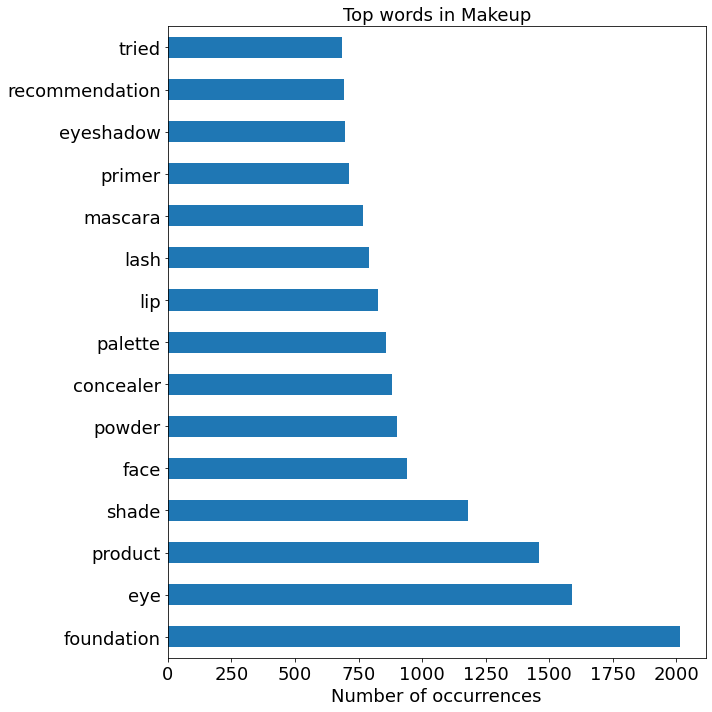

In [93]:
plot_top_words('Makeup', 0, 'title_selftext_lemmatized', 1, 1, 15)

Top words in Makeup consists of different makeup products and different areas of the face where makeup is applied.

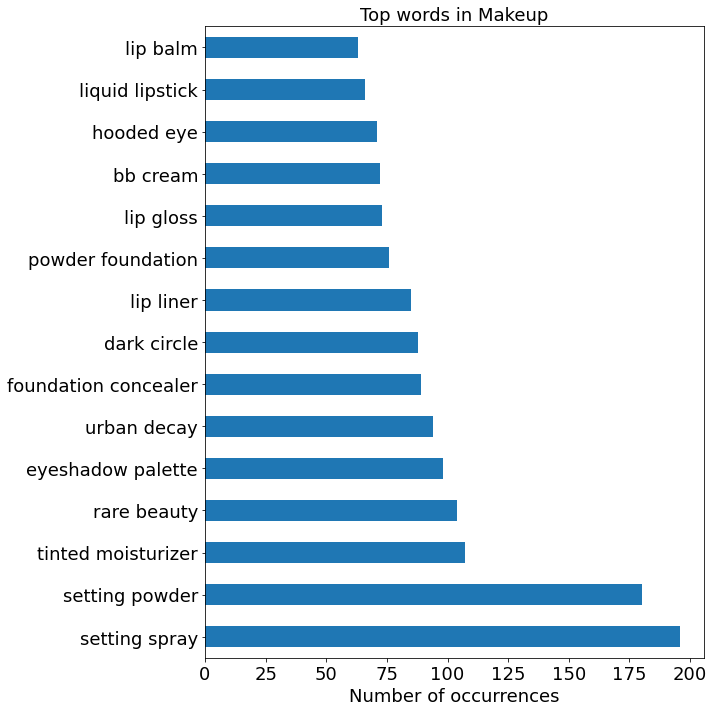

In [94]:
plot_top_words('Makeup', 0, 'title_selftext_lemmatized', 2, 2, 15)

Top bigrams in Makeup consists of different 2-word makeup products, makeup brands which can be useful for our Marketing department to analyse if they are our top selling products and brands.

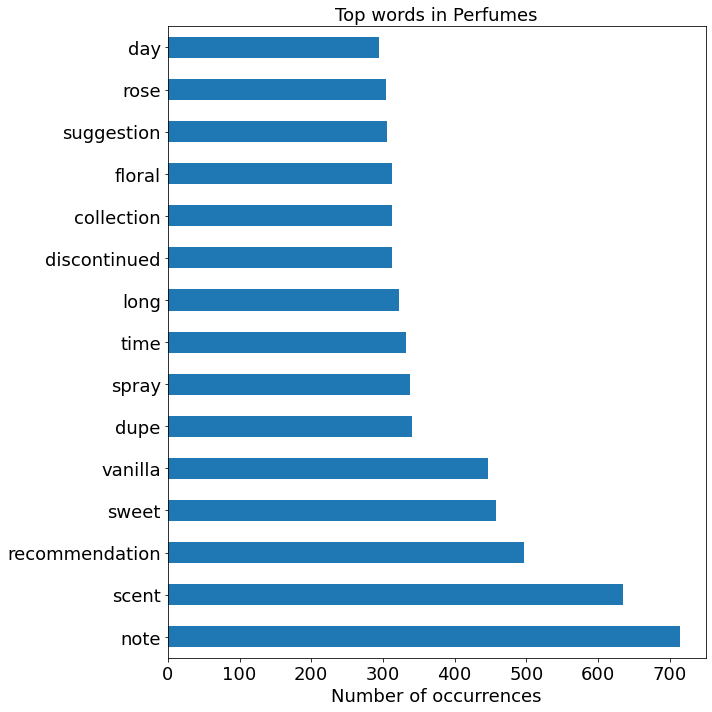

In [95]:
plot_top_words('Perfumes', 1, 'title_selftext_lemmatized', 1, 1, 15)

Top words in Perfumes are words related to the smell like "vanilla', 'sweet', 'floral'.

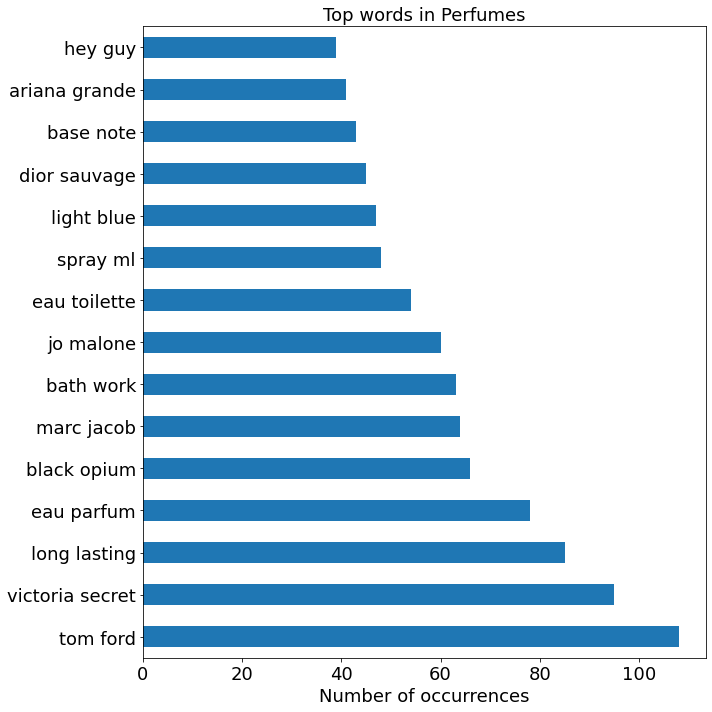

In [96]:
plot_top_words('Perfumes', 1, 'title_selftext_lemmatized', 2, 2, 15)

Top bigrams in Perfumes shows popular brands like Tom Ford, Victoria Secret. We also can infer most of the users are looking for lost lasting fragrances

In [97]:
# Saving clean data to csv
makeup_perfumes.to_csv('../data/makeup_perfumes.csv', index=False)